This is a tutorial for conditional variational encoders

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import datetime
import tensorboard as tb
import time
%load_ext tensorboard

download the training data from keras

In [2]:
(images,labels),(_,_)=tf.keras.datasets.mnist.load_data()

preprocessing the input images involves normalizing and binarizing the images, as well as adding the additional channel dimension as Conv2D takes 4 dimensional tensors as inputs.

In [3]:
def preprocess_images(images):
    images = images.astype('float32')
    images/=255
    images[images>=0.5]=1.0
    images[images<0.5]=0.0
    images = tf.expand_dims(images,axis = -1)
    return images

Preprocss the training images and create one hot encodings for the labels

In [4]:
images = preprocess_images(images)
one_hot_labels = np.eye(10)[labels].astype('float32')

create and batch our dataset, a larger batch size is desired since we want to increase the accuracy of expectation approximation

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((images,one_hot_labels)).shuffle(10000).batch(100)

checking to see if the batched data makes sense

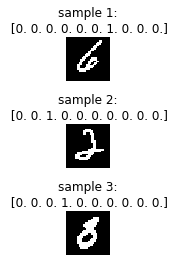

In [6]:
iterator = iter(dataset)
sample_image, sample_label = next(iterator)

for i in range(3):
    choice = np.random.choice(100)
    ax = plt.subplot(3,1,i+1)
    plt.subplots_adjust(hspace = 1)
    ax.set_title("sample {}:\n {}".format(i+1,np.array(sample_label[choice])))
    plt.imshow(tf.squeeze(sample_image[choice]),cmap='gray')
    plt.axis('off')

The enocder $q_{\phi}(z|x_i)$ maps each instance of data $x_i$ onto a instance of $z$ the latent space
The input is the training image and the output is a (batchsize,latent_dim x 2) shaped tensor which will then be split into the $\mu$ and $\sigma^2$ values for reparametization.

In [7]:
latent_dim = 50
n_filters = 32

In [8]:
class Encoder(Model):
    def __init__(self,n_filters,latent_dim):
        super(Encoder,self).__init__()
        # input shape = (100,28,28,1) target output shape = (100,50+50)
        self.conv1 = layers.Conv2D(n_filters,kernel_size = (3,3),strides = 2,padding = 'SAME',activation = 'sigmoid')
        self.conv2 = layers.Conv2D(n_filters*2,kernel_size = (3,3),strides = 2,padding = 'SAME',activation = 'sigmoid')
        self.flat = layers.Flatten()
        self.encoding = layers.Dense(latent_dim*2)

    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flat(x)
        x = self.encoding(x)
        return x

The classifer predicts the class that the input images belong to. The predicted class will be concatenated to the latent vector to allow the conditioning of the latent variable $z$ when we want to generate images of a specific class via the decoder. 

In [9]:
class Classifier(Model):
    def __init__(self,n_filters):
        super(Classifier,self).__init__()
        # input shape = (100,28,28,1) target output shape = (100,10)
        self.conv1 = layers.Conv2D(n_filters,kernel_size = 3,strides = (2,2),padding = 'SAME',activation = 'sigmoid')
        self.conv2 = layers.Conv2D(n_filters*2,kernel_size = 3,strides = (2,2),padding = 'SAME',activation = 'sigmoid')
        self.flat = layers.Flatten()
        self.class_prediction = layers.Dense(10,activation='softmax')

    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flat(x)
        x = self.class_prediction(x)
        return x

The decoder $p_{\theta}(x|z)$ takes the encoded latent vector and generate an image by sampling from $z$. Again reparameterization is required to properly train the decoder jointly with the encoder.

In [10]:
class Decoder(Model):
    def __init__(self,n_filters):
        super(Decoder,self).__init__()
        # input shape = (100,60) target output shape = (100,28,28,1)
        self.dense1 = layers.Dense(7*7*32,activation = 'relu')
        self.reshape = layers.Reshape((7,7,32))
        self.conv1 = layers.Conv2DTranspose(n_filters*2,kernel_size = 3,strides = (2,2),padding = 'SAME',activation = 'sigmoid')
        self.conv2 = layers.Conv2DTranspose(n_filters,kernel_size = 3,strides = (2,2),padding = 'SAME',activation = 'sigmoid')
        self.generated_image = layers.Conv2DTranspose(1,kernel_size = 3,strides = (1,1),padding = 'SAME')

    def call(self,inputs):
        x = self.dense1(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.generated_image(x)
        return x

To ensure that the gradients from the decoder passes through to update the encoder, we need to reparameterize the latent variable z as:
\begin{align}
z = \mu+\sigma^2x\\
\end{align}
where x is sampled from a normal distribution with $\mu = 0, \sigma^2 = 1$ and $\mu, \sigma$ are outputs from the encoder.

In [11]:
def Reparameterize(mean,logvar,noise,training = True):
    # image_encoding = (100,100), predicted_label = (100,10), noise = (100,50)
    # target shape = (100,60)
    
    if training:
        z=noise*tf.exp(logvar * 0.5)+mean
    else:
        z = noise
    return z

The normal pdf is given as:
\begin{align}
f(x|\mu\sigma^2) = \frac{e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}}\\
\end{align}
By Taking the log of the above pdf function:
\begin{align}
log\hspace{0.1cm}f = -\frac{1}{2}(\frac{(x-\mu)^2}{\sigma^2}+log\hspace{0.1cm}2\pi+log\hspace{0.1cm}\sigma^2)\\
\end{align}
And since we have taken the output of the encoder to be $\mu$ and $log var$ for stability purposes, our equation becomes:
\begin{align}
log\hspace{0.1cm}f = -\frac{1}{2}(\frac{(x-\mu)^2}{e^{logvar}}+log\hspace{0.1cm}2\pi+logvar)\\
\end{align}

In [12]:
def logPDF(mean,logvar,z):
    logf = -0.5*((z-mean)**2/tf.math.exp(logvar)+tf.math.log(2*np.pi))
    return logf

The loss function is the negative of the ELBO:
\begin{align}
ELBO = E_{z\sim q_{\phi}(z)}log\hspace{0.1cm}p(z)+log\hspace{0.1cm}p_{\theta}(x|z)-log\hspace{0.1cm}q_{\phi}(z)\\
\end{align}
Where $$log\hspace{0.1cm}p(z)$$ is the $log\hspace{0.1cm}f$ of the normal distribution with $\mu=0, \sigma^2=1$,
$$log\hspace{0.1cm}q_{\phi}(z)$$ is the $log\hspace{0.1cm}f$ of the latent cluster generated by the encoder $q_{\phi}(z)$
and $$log\hspace{0.1cm}p_{\theta}(x|z)$$ is simply the log of the reconstruction loss
In the case of conditional VAEs we can add the classifier cross entropy loss in addition to the above losses

In practice the expectation is taken via MCMC sampling in the form of batched data, which means we can benifit from larger batches and we need to take the mean of the losses as a measure of our approximate expectations. This is a very natrual thing to do in tensorflow. 

In [13]:
def LossFunction(z,mean,logvar,generated_image,predicted_label,true_label,input_image,cls_weight = 10.0):
    logpz = tf.reduce_sum(logPDF(0.0,0.0,z),axis = -1)
    logqz = tf.reduce_sum(logPDF(mean,logvar,z),axis = -1)
    logpxz = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels = input_image,logits = generated_image), 
                           axis = [1,2,3])
    class_loss = tf.keras.losses.CategoricalCrossentropy()(true_label,predicted_label)
    
    total_loss = tf.reduce_mean(-logpz-logpxz+logqz)+cls_weight*class_loss
    return total_loss

Lets bring the previously defined model together under one one umbrella; we'll call this model CVAE. We will also create a method for the CVAE that would also allow us to generate specific samples from the latent space $z$.

In [14]:
class CVAE(Model):
    def __init__(self,n_filters,latent_dim):
        super(CVAE,self).__init__()
        self.encoder = Encoder(n_filters,latent_dim)
        self.decoder = Decoder(n_filters)
        self.classifier = Classifier(n_filters)
    
    def generate(self,numbers,save = True, image_name = None):
        labels = np.eye(10)[numbers].astype('float32')
        noise = tf.random.normal(shape = (len(numbers),50))
        conditioned_z = tf.concat([noise,labels],axis = -1)
        generated_samples = tf.nn.sigmoid(self.decoder(conditioned_z))

        fig = plt.figure(figsize=(4,4))
        for i in range(len(numbers)):
            plt.subplot(4, 4, i+1)
            plt.imshow(tf.squeeze(generated_samples[i]), cmap='gray')
            plt.axis('off')
        
        if save:
            plt.savefig(image_name)
            plt.show()
        return generated_samples
    
    def call(self,training_images,training = True):
        x = self.encoder(training_images)
        mean = x[:,:50]
        logvar = x[:,50::]
        predicted_label = self.classifier(training_images)
        noise = tf.random.normal(shape = (100,50))
        z = Reparameterize(mean,logvar,noise)
        conditioned_z = tf.concat([z,predicted_label],axis = -1)
        generated_image = self.decoder(conditioned_z)
        return z,mean,logvar,generated_image,predicted_label

In [15]:
optimizer = tf.keras.optimizers.Adam(1e-4)
cvae = CVAE(n_filters,latent_dim)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

@tf.function
def train_step(image,label):
    with tf.GradientTape() as tape:
        z,mean,logvar,generated_image,predicted_label = cvae(image)
        loss = LossFunction(z,mean,logvar,generated_image,predicted_label,label,image)
        
    gradients = tape.gradient(loss,cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients,cvae.trainable_variables))
    
    train_loss(loss)

In [16]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

training loss epoch 1: 283.0182189941406
training loss epoch 2: 203.65635681152344
training loss epoch 3: 134.06314086914062
training loss epoch 4: 84.8983383178711
training loss epoch 5: 66.2369155883789
training loss epoch 6: 55.496036529541016
training loss epoch 7: 47.856956481933594
training loss epoch 8: 41.93791961669922
training loss epoch 9: 37.244083404541016
training loss epoch 10: 33.450164794921875
Sample generated epoch10.
 Average time per epoch: 4.544811129570007


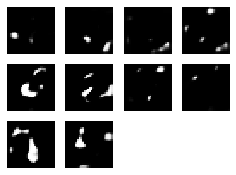

training loss epoch 11: 30.442493438720703
training loss epoch 12: 27.674625396728516
training loss epoch 13: 25.46893310546875
training loss epoch 14: 23.40621566772461
training loss epoch 15: 21.645498275756836
training loss epoch 16: 20.14805030822754
training loss epoch 17: 18.628334045410156
training loss epoch 18: 17.234275817871094
training loss epoch 19: 15.998090744018555
training loss epoch 20: 14.911256790161133
Sample generated epoch20.
 Average time per epoch: 4.834554076194763


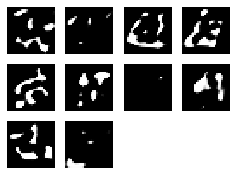

training loss epoch 21: 13.880159378051758
training loss epoch 22: 12.895854949951172
training loss epoch 23: 11.907121658325195
training loss epoch 24: 11.034451484680176
training loss epoch 25: 10.754042625427246
training loss epoch 26: 9.982824325561523
training loss epoch 27: 9.5271635055542
training loss epoch 28: 9.112024307250977
training loss epoch 29: 9.640050888061523
training loss epoch 30: 10.448416709899902
Sample generated epoch30.
 Average time per epoch: 4.298808455467224


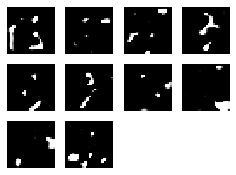

training loss epoch 31: 10.375163078308105
training loss epoch 32: 9.794407844543457
training loss epoch 33: 9.297913551330566
training loss epoch 34: 10.617035865783691
training loss epoch 35: 11.543299674987793
training loss epoch 36: 11.616263389587402
training loss epoch 37: 11.4186429977417
training loss epoch 38: 11.822399139404297
training loss epoch 39: 11.9124755859375
training loss epoch 40: 11.815019607543945
Sample generated epoch40.
 Average time per epoch: 4.528384947776795


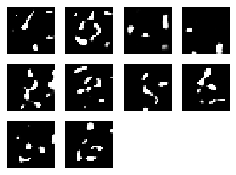

training loss epoch 41: 12.598308563232422
training loss epoch 42: 13.067091941833496
training loss epoch 43: 13.45019245147705
training loss epoch 44: 14.040361404418945
training loss epoch 45: 14.581123352050781
training loss epoch 46: 14.690970420837402
training loss epoch 47: 14.4856538772583
training loss epoch 48: 14.424822807312012
training loss epoch 49: 15.091423988342285
training loss epoch 50: 15.623136520385742
Sample generated epoch50.
 Average time per epoch: 4.276216125488281


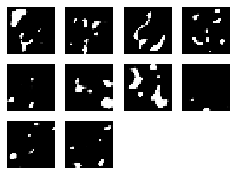

training loss epoch 51: 15.4925537109375
training loss epoch 52: 15.246261596679688
training loss epoch 53: 15.388038635253906
training loss epoch 54: 15.356736183166504
training loss epoch 55: 15.128588676452637
training loss epoch 56: 14.905519485473633
training loss epoch 57: 14.75200366973877
training loss epoch 58: 14.54460620880127
training loss epoch 59: 14.389457702636719
training loss epoch 60: 14.632140159606934
Sample generated epoch60.
 Average time per epoch: 4.262491393089294


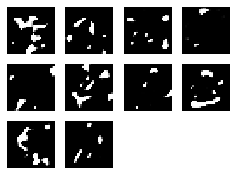

training loss epoch 61: 14.504009246826172
training loss epoch 62: 14.42588996887207
training loss epoch 63: 14.535921096801758
training loss epoch 64: 15.636216163635254
training loss epoch 65: 15.912850379943848
training loss epoch 66: 15.798235893249512
training loss epoch 67: 15.792553901672363
training loss epoch 68: 16.0272274017334
training loss epoch 69: 15.905779838562012
training loss epoch 70: 15.781917572021484
Sample generated epoch70.
 Average time per epoch: 4.311218523979187


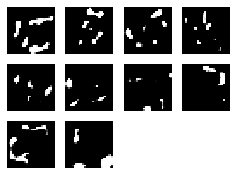

training loss epoch 71: 15.63541030883789
training loss epoch 72: 15.49319839477539
training loss epoch 73: 15.429360389709473
training loss epoch 74: 15.619359970092773
training loss epoch 75: 15.717535972595215
training loss epoch 76: 16.060579299926758
training loss epoch 77: 15.933752059936523
training loss epoch 78: 15.845312118530273
training loss epoch 79: 15.745439529418945
training loss epoch 80: 15.609451293945312
Sample generated epoch80.
 Average time per epoch: 4.4134458065032955


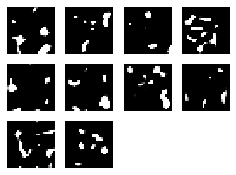

training loss epoch 81: 15.517965316772461
training loss epoch 82: 15.45813274383545
training loss epoch 83: 15.610004425048828
training loss epoch 84: 15.759231567382812
training loss epoch 85: 15.677264213562012
training loss epoch 86: 15.545601844787598
training loss epoch 87: 15.459298133850098
training loss epoch 88: 15.3872709274292
training loss epoch 89: 15.607141494750977
training loss epoch 90: 15.696699142456055
Sample generated epoch90.
 Average time per epoch: 4.3574649572372435


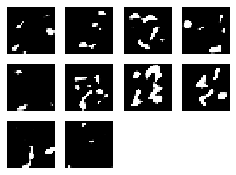

training loss epoch 91: 15.652237892150879
training loss epoch 92: 15.532198905944824
training loss epoch 93: 15.822827339172363
training loss epoch 94: 15.886720657348633
training loss epoch 95: 15.993797302246094
training loss epoch 96: 16.220901489257812
training loss epoch 97: 16.165908813476562
training loss epoch 98: 16.094554901123047
training loss epoch 99: 16.033727645874023
training loss epoch 100: 15.985162734985352
Sample generated epoch100.
 Average time per epoch: 4.291508746147156


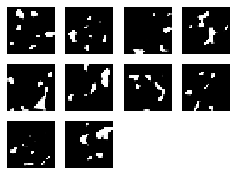

In [17]:
start_time = time.time()
for epoch in range(1,101):
    for image,label in iter(dataset):
        train_step(image,label)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
    print("training loss epoch {}: {}".format(epoch,train_loss.result()))
    if epoch % 10==0:
        image_name = 'epoch{}_samples.png'.format(epoch)
        print("Sample generated epoch{}.\n Average time per epoch: {}".format(epoch,(time.time()-start_time)/10))
        cvae.generate(np.arange(10),save = True, image_name = image_name)
        start_time = time.time()
    train_loss.reset_states()